In [1]:
import os 
import sys
sys.path.append('../dependencies/')

import shutil
import flopy
# import specific FloPy modules
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# for working with shapefiles
import shapefile as sf
from shapely.geometry import Polygon, LineString, MultiLineString, Point

print(f'Flopy version:{flopy.__version__}')

Flopy version:3.9.2


# Adding a transport model

In this exercise we will add a transport model to a previsouly developed flow model. There is no reason why this couldn't have been done all in one step. I am just taking the oportunity to demonstrate how to edit pre-exsiting models.

We are going to:
 - load the exsiting flow model
 - add a transport model
 - add mass BCs
 - add concentration observations

In [2]:
# define the location of the model working directory; this is where all the MF6 files will be written
# the folder path is relative to the location in which python is running. In our case, relative to the location of the jupyter notebok file.
org_workspace = os.path.join('..','models','sgn_model_1layer')  

workspace = os.path.join('..','models','sgn_model_1layer_transport')

# make sure that the folder exists. If it doesn't, create it.
# copy the hisotry model to the new folder
if os.path.exists(workspace):
    shutil.rmtree(workspace)
shutil.copytree(org_workspace, workspace)    

# the relative pathto the input file folder
datadir = os.path.join('..','data','sgn')

# the relative path to the executables folder
bindir = os.path.join('..','bin')

In [3]:
# get the spatial refernce from the model
sim = flopy.mf6.MFSimulation.load(sim_ws=workspace)

print(sim.model_names)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package riv...
    loading package drn...
    loading package wel...
    loading package ghb...
    loading package obs...
    loading package oc...
  loading solution package sgn...
['sgn']


In [4]:
gwf = sim.get_model("sgn")

In [5]:
# Time for transport: 1576800000 seconds = 50 years
sim.tdis.perioddata.set_data([(1576800000., 4, 1.1)])
sim.tdis.perioddata

{internal}
(rec.array([(1.5768e+09, 4, 1.1)],
          dtype=[('perlen', '<f8'), ('nstp', '<i4'), ('tsmult', '<f8')]))

In [6]:
# Instantiate storage package
sto =flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0, steady_state=[True],filename="{}.sto".format(gwf.name))

In [7]:
# Instantiating MODFLOW 6 groundwater transport package
name='sgn'
gwtname = "gwt-" + name

gwt = flopy.mf6.MFModel(
    sim,
    model_type="gwt6",
    modelname=gwtname,
    model_nam_file="{}.nam".format(gwtname),
)
gwt.name_file.save_flows = True

# create iterative model solution and register the gwt model with it
nouter, ninner = 100, 500
hclose, rclose, relax = 1e-6, 1e-6, 1.0

imsgwt = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="BICGSTAB",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename="{}.ims".format(gwtname),
)
sim.register_ims_package(imsgwt, [gwt.name])

# Instantiating MODFLOW 6 transport discretization package
flopy.mf6.ModflowGwtdisv(
    gwt,
    nlay=gwf.dis.nlay.get_data(), 
    ncpl=gwf.dis.ncpl.get_data(),
    length_units=gwf.dis.length_units.get_data(),
    top=gwf.dis.top.get_data(),
    botm=gwf.dis.botm.get_data(),
    nvert=gwf.dis.nvert.get_data(), 
    vertices=gwf.dis.vertices.get_data(), 
    cell2d=gwf.dis.cell2d.get_data(),
    idomain=gwf.dis.idomain.get_data(),
    filename="{}.dis".format(gwtname),
)

# Instantiating MODFLOW 6 transport initial concentrations
sconc = 0.0
flopy.mf6.ModflowGwtic(
    gwt, strt=sconc, filename="{}.ic".format(gwtname)
)

# Instantiating MODFLOW 6 transport advection package
scheme = "UPSTREAM"

flopy.mf6.ModflowGwtadv(
    gwt, scheme=scheme, filename="{}.adv".format(gwtname)
)

# Instantiating MODFLOW 6 transport dispersion package
al = 30  # Longitudinal dispersivity ($m$)
# Dispersion
ath1 = 3
atv = 3
dmcoef = 1.02E-9  # m^2/s

flopy.mf6.ModflowGwtdsp(
    gwt,
    alh=al,
    ath1=ath1,
    atv=atv,
    diffc=dmcoef,
    pname="DSP-1",
    filename="{}.dsp".format(gwtname),
)

# Instantiating MODFLOW 6 transport mass storage package
prsity = 0.2

flopy.mf6.ModflowGwtmst(
    gwt,
    porosity=prsity,
    pname="MST-1",
    filename="{}.mst".format(gwtname),
)

# Instantiating MODFLOW 6 transport source-sink mixing package
sourcerecarray = [()]#("CHD-1", "AUX", "CONCENTRATION")]
flopy.mf6.ModflowGwtssm(
    gwt,
    sources=sourcerecarray,
    print_flows=True,
    filename="{}.ssm".format(gwtname),
)

# Instantiating MODFLOW 6 transport output control package
flopy.mf6.ModflowGwtoc(
    gwt,
    budget_filerecord="{}.cbc".format(gwtname),
    concentration_filerecord="{}.ucn".format(gwtname),
    concentrationprintrecord=[
        ("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")
    ],
    saverecord=[
        ("CONCENTRATION", "LAST"),
        ("BUDGET", "LAST"),
    ],
    printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    filename="{}.oc".format(gwtname),
)

# Instantiating MODFLOW 6 flow-transport exchange mechanism
flopy.mf6.ModflowGwfgwt(
    sim,
    exgtype="GWF6-GWT6",
    exgmnamea="sgn",
    exgmnameb=gwtname,
    filename="{}.gwfgwt".format(name),
)

package_name = sgn.gwfgwt
filename = sgn.gwfgwt
package_type = gwfgwt
model_or_simulation_package = simulation
simulation_name = modflowsim


In [ ]:
# GridIntersect works by first calling an intersect object on the model grid:
ix = GridIntersect(gwf.modelgrid)

# the path to the shapefile
conc_shpfile = os.path.join(datadir, 'shp', 'real_unknown_sources.shp')
# use the sf.Reader function to load the shape as a sf Shapefile object
read_conc = sf.Reader(conc_shpfile)
conc_shapes = read_conc.shapes()

conc_spd=[]
# for each feature in the shapefile
for i in range(len(conc_shapes)):
    shp = conc_shapes[i]
    # the shapefile records contain the concentration in the second to last attribute "column"; the fourth to last identfies the source location
    record = read_conc.record(i)
    conc_i = record[-2]
    conc_site = record[-4]

    # get the intersect
    cellids = ix.intersect(shp).cellids
    for icpl in cellids:
        conc_spd.append(((0, icpl), conc_i, f'conc-{conc_site}'))


cnc = flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=conc_spd, boundnames=True)

In [ ]:
# observations

# the path to the shapefile
obs_shpfile = os.path.join(datadir, 'shp', 'Target_L1_sept2019_head_PCE.shp')
# use the sf.Reader function to load the shape as a sf Shapefile object
read_obs = sf.Reader(obs_shpfile)
obs_shapes = read_obs.shapes()


obs_list=[]
# for each feature in the shapefile
for i in range(len(obs_shapes)):
    
    shp = obs_shapes[i]
    cellids = ix.intersect(shp).cellids

    record = read_obs.record(i)
    piezid = record[0]
    for icpl in cellids:
        obs_list.append((f'{piezid}', 'CONCENTRATION', (0, icpl))) # assume layer 1

obs_recarray = {'conc_obs.csv':obs_list}

# initialize obs package
obs_package = flopy.mf6.ModflowUtlobs(gwt, 
                                      digits=10, print_input=True,
                                      continuous=obs_recarray)

In [10]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package sgn...
  writing solution package ims_0...
  writing package sgn.gwfgwt...
  writing model sgn...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rch_obs...
    writing package rch...
    writing package riv_obs...
    writing package riv_0...
    writing package drn_obs...
    writing package drn_0...
    writing package wel_obs...
    writing package wel_0...
    writing package ghb_obs...
    writing package ghb_0...
    writing package obs_5...
    writing package oc...
    writing package sto...
  writing model gwt-sgn...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package adv...
    writing package dsp-1...
    writing package mst-1...
    writing package ssm...
    writing package oc...
    writing package cnc_0...
INFORMATION

In [11]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\..\..\..\..\..\..\..\EXE\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 02/06/2022
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Feb 06 2022 02:35:51 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neithe

(True, [])

In [12]:
fname = os.path.join(workspace, gwf.name + '.hds')
hdobj = flopy.utils.HeadFile(fname, model=gwf)
head = hdobj.get_alldata()

hmin = head.min()
hmax = head.max()

print(f'Max head in model run: {hmax}')
print(f'Min head in model run: {hmin}')

head.shape

Max head in model run: 103.02477792723084
Min head in model run: 97.08266061912798


(1, 1, 1, 19131)

<Axes: title={'center': 'data Layer 1'}>

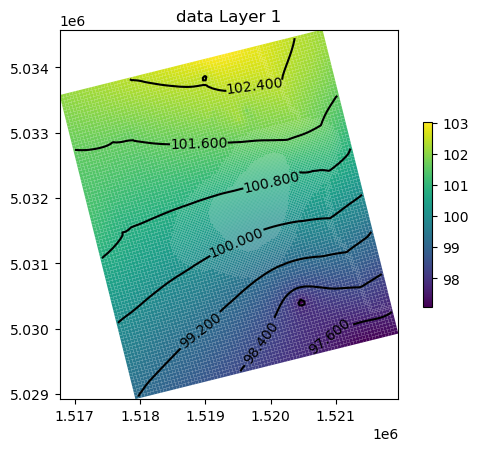

In [13]:
# get the times at which values are recorede in the heads file
hdtimes = hdobj.get_times()
# generic plot of head data
hdobj.plot(mflay=0, totim=hdtimes[0] ,colorbar=True, contour=True, clabel=True)

In [14]:
 #Get the MF6 concentration output
fname_mf6 = os.path.join(workspace, list(sim.model_names)[1] + ".ucn")
ucnobj_mf6 = flopy.utils.HeadFile(fname_mf6, precision="double", text="CONCENTRATION")

times_mf6 = ucnobj_mf6.get_times()
conc_mf6 = ucnobj_mf6.get_alldata()

In [15]:
# get the head output
fname = os.path.join(workspace, list(sim.model_names)[0] + '.hds')
hdobj = flopy.utils.HeadFile(fname, model=gwf)
head = hdobj.get_alldata()

hmin = head.min()
hmax = head.max()

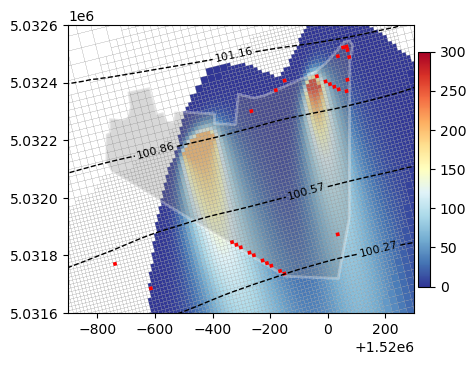

In [16]:
fig = plt.figure(figsize=(5, 5), tight_layout=True)
ax = fig.add_subplot(111, aspect='equal')

ext_offset = 500
extent=(1519100, 1520300, #xmin, xmax
        5031600, 5032600) #ymin, ymax


# plot the grid
mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0, extent=extent) # 1519614., 5031870.


# plot head isolines
cint = (hmax-hmin)/20
levels = np.arange(np.floor(hmin), np.ceil(hmax) + cint, cint)
cs = mm.contour_array(head[0, 0, 0, :], colors='black', levels=levels, linestyles="--", linewidths=1)
plt.clabel(cs, fmt='%.2f', fontsize=8, inline=True)


# plot the concentration
a = ucnobj_mf6.get_data(mflay=0)[0]
a[a<0.1] = np.nan

ca = mm.plot_array(edgecolor='grey', a=a, cmap='RdYlBu_r',   alpha=1, linewidth=0.1, vmin=0, vmax=300)
cb = plt.colorbar(ca, shrink=0.5, pad=0.01, )

flopy.plot.plot_shapefile(sf.Reader(os.path.join(datadir, 'shp','Site_area.shp')), linewidth=2, facecolor='grey', edgecolor='w', alpha=0.3);
# plot the well cells
wells = mm.plot_bc("WEL")